In [1]:
import networkx as nx
import numpy as np
from matplotlib.pyplot import *
from sklearn.metrics import mean_squared_error
import os
import scipy
from math import sqrt

In [2]:
from preprocessing_net import get_cyclic_net
from ESN_class import ESN
from mutual_info import memory_capacity_n
from nrmse_calc import nrmse, nrmse_n

In [3]:
#ESN_class.py imports
import networkx as nx
import numpy as np
from sampling import random_sampling_normal_from_range
import random as rand
import scipy
from preprocessing_net import get_cyclic_net

In [4]:
class ESN(object):
    def __init__(self, filename, in_size, out_size, spectral_radius):
        self.res_size= self.build_adj_weighted_matrix(filename).shape[0]
        self.in_size=in_size
        self.out_size=out_size
        self.spectral_radius= spectral_radius
        self.W0=self.build_adj_weighted_matrix(filename)
        self.W=None
        self.Win=None
        self.Wout=None
        self.X=None
        self.Y=None
        self.x=np.zeros((self.res_size,1))
        self.x0=np.insert(np.random.rand(self.res_size),0,[1.0,1.0,1.0])
        self.decay=random_sampling_normal_from_range([1/5,1/60],(self.res_size,1))
        #self.decay=np.random.rand(self.res_size).reshape((self.res_size,1))
        self.u=None
        self.x_act=None

    
    def build_adj_weighted_matrix(self, filename):
        #NETWORK v2.0
        net=get_cyclic_net(filename)
        for edge in net.edges(data="mode", default=0):
            source,target,mode=edge
            if mode== "+":
                net[source][target]["weight"]= rand.uniform(0,1)
            elif mode== "-":
                net[source][target]["weight"]= rand.uniform(0,-1)
            elif mode== 0:
                net[source][target]["weight"]= rand.uniform(-1,1)
        return nx.to_numpy_matrix(net)
    
    def initialize(self): 
        np.random.seed(42)
        self.Win=np.random.choice([-0.05,0.05], size=(self.res_size,1+self.in_size))
        self.W0 = np.squeeze(np.asarray(self.W0))
        rhoW0 = max(abs(scipy.linalg.eig(self.W0)[0]))
        self.W= (self.spectral_radius/rhoW0)*self.W0
        

    def collect_states(self, data, init_len, train_len, a=0.3):
        self.X=np.zeros((self.res_size+self.in_size+1, train_len-init_len))
        for t in range(train_len):
            u = data[t]
            self.x = (1-a)*self.x + a*np.tanh( np.dot( self.Win, np.vstack((1,u)) ) + np.dot( self.W, self.x ) ) 
            if t >= init_len:
                self.X[:,t-init_len]= np.vstack((1,u,self.x))[:,0]
        
        return self.X
    
    
    def collect_states_derivative(self, a,b,c, init_len, train_len, test_len):
        self.X=np.zeros((self.res_size+self.in_size+1, train_len-init_len))
        t=np.arange(train_len+test_len)
        uyz_x=scipy.integrate.odeint(self.dx_dt,self.x0,t,args=(a,b,c,self.decay))
        self.u=uyz_x[:,0]+20
        self.x_act=uyz_x[:,3:]
        print(np.any(self.x_act<0))
        plot( t[0:200],self.x_act[0:200] )
        for t in range(init_len,train_len):
            x_concat=self.x_act[t,:].reshape(self.x_act[t,:].shape[0],1)
            u_concat=self.u[t]
            self.X[:,t-init_len]= np.vstack((1,u_concat,x_concat))[:,0]
               
        return self.X
    
    def dx_dt(self, uyz_x,t,a,b,c,decay):
        u=uyz_x[0]
        y=uyz_x[1]
        z=uyz_x[2]
        x=np.array(uyz_x[3:]).reshape(self.res_size,1)
       
        du_dt=-z-y
        dy_dt=u+a*y
        dz_dt=b+z*(u-c)
        dx_dt=0.5*(np.tanh( np.dot( self.Win, np.vstack((1,u+20)) ) + np.dot( self.W, x ) )+1) - (decay * x)
        return np.insert(dx_dt,0,[du_dt,dy_dt,dz_dt])
        
    def calculate_weights(self, data, init_len, train_len,beta=1e-8 ):
        Y=data[None,init_len+1:train_len+1]
        X_T=self.X.T
        self.Wout= np.dot ( np.dot(Y, X_T), np.linalg.inv(np.dot(self.X,X_T) + beta * np.eye(self.res_size+self.in_size+1)))
        return self.Wout
    
    def calculate_weights_derivative(self,init_len, train_len, n, beta=1e-8 ):
        Y=np.array([self.u[init_len+1-n:train_len+1-n]])
        X_T=self.X.T
        self.Wout= np.dot ( np.dot(Y, X_T), np.linalg.inv(np.dot(self.X,X_T) + beta * np.eye(self.res_size+self.in_size+1))) #w= y*x_t*(x*x_t + beta*I)^-1
        return self.Wout
    
    def run_generative(self, data, test_len, train_len,a=0.3):
        self.Y = np.zeros((self.out_size,test_len))
        u = data[train_len]
        for t in range(test_len):
            self.x = (1-a)*self.x + a*np.tanh( np.dot( self.Win, np.vstack((1,u)) ) + np.dot( self.W, self.x ) ) 
            y = np.dot( self.Wout, np.vstack((1,u,self.x)) )
            self.Y[:,t] = y
            u = data[trainLen+t+1]
            #u =y
    
    def run_predictive_derivative(self, a,b,c, test_len, train_len):
        self.Y = np.zeros((self.out_size,test_len))
        
        for t in range(train_len,train_len+test_len):
            x_concat=self.x_act[t,:].reshape(self.x_act[t,:].shape[0],1)
            u_concat=self.u[t]
            y = np.dot( self.Wout, np.vstack((1,u_concat,x_concat)) )
            self.Y[:,t-train_len] = y
           
        
        return self.Y


In [5]:
(np.random.rand(13)*np.random.rand(13)).shape

(13,)

In [6]:
##################################################################################

In [7]:
#                                   FUNCTIONS                                    #

In [8]:
def testing_gene_net(directory,input_data,data):
    csv_files= [file for file in os.listdir(directory) if file.startswith("network_edge_list")]
    print(csv_files)
    MI_by_file={}
    for file in csv_files:
        filename=file[file.index("list")+5:file.index(".csv")]
        net=ESN(os.path.join(directory, file),1,1,0.95)
        net.initialize()
        net.collect_states(input_data,initLen,trainLen)
        net.calculate_weights(input_data,initLen,trainLen)
        net.run_generative(input_data,testLen,trainLen)
        MI_by_file[filename]=memory_capacity_n(net.Y, data,100)
        nrmse= sqrt(mean_squared_error(data[trainLen+1:trainLen+errorLen+1],net.Y[0,0:errorLen])/np.std(net.Y[0,0:errorLen]))
        print(net.res_size, 'NRMSE = ' + str( nrmse ))
        print(memory_capacity_n(net.Y, data,20))
        
    return MI_by_file

In [9]:
def testing_gene_net_file(directory,file):
    print(file)
    filename=file[file.index("list")+5:file.index(".csv")]
    net=ESN(os.path.join(directory, file),1,1,0.95)
    net.initialize()
    net.collect_states(data,initLen,trainLen)
    net.calculate_weights(data,initLen,trainLen)
    net.run_generative(data,testLen,trainLen)
    nrmse= sqrt(mean_squared_error(data[trainLen+1:trainLen+errorLen+1],net.Y[0,0:errorLen])/np.std(net.Y[0,0:errorLen]))
    print(net.res_size, 'NRMSE = ' + str( nrmse ))
    return memory_capacity_n(net.Y, data,100)

In [10]:
def testing_gene_net_derivative(directory,a,b,c,n,i_max=80):
    #init
    csv_files= [file for file in os.listdir(directory) if file.startswith("network_edge_list")]
    Y_by_file={}
    X_by_file={}
    MI_by_file={}
    NRMSE_by_file={}
    
    for file in csv_files:
        #init
        print(file)
        filename=file[file.index("list")+5:file.index(".csv")]
        
        #Run network
        net=ESN(os.path.join(directory, file),1,1,0.95)
        net.initialize()
        net.collect_states_derivative(a,b,c,initLen,trainLen,testLen)
        net.calculate_weights_derivative(initLen,trainLen,n)
        net.run_predictive_derivative(a,b,c,testLen,trainLen)
        
        #Calculate output
        X_by_file[filename]=net.u
        Y_by_file[filename]=net.Y
        MI_by_file[filename]=memory_capacity_n(net.Y, net.u,n)
        NRMSE_by_file[filename]=nrmse_n(net.Y,net.u,i_max,errorLen,trainLen)
        
        #prints
        
        print(nrmse(net.Y[0,0:errorLen],net.u[trainLen+1:trainLen+errorLen+1]))
        print(net.res_size, " FINISHED")
    return X_by_file, Y_by_file, NRMSE_by_file, MI_by_file
  


In [11]:
def testing_gene_net_derivative_file(directory,file,a,b,c,n,i_max=80):
    #init
    print(file)
    filename=file[file.index("list")+5:file.index(".csv")]
    
    #Run network
    net=ESN(os.path.join(directory, file),1,1,0.95)
    net.initialize()
    net.collect_states_derivative(a,b,c,initLen,trainLen,testLen)
    net.calculate_weights_derivative(initLen,trainLen,n)
    net.run_predictive_derivative(a,b,c,testLen,trainLen)
    
    #Calculate output
    X=net.u
    Y=net.Y
    mi_i=memory_capacity_n(net.Y, net.u,n)
    nrmse_i=nrmse_n(net.Y,net.u,i_max,errorLen,trainLen)
    
    #prints
    print(nrmse(net.Y[0,0:errorLen],net.u[trainLen+1:trainLen+errorLen+1]))
    print(net.res_size, " FINISHED")
    
    return X,Y,nrmse_i,mi_i

In [12]:
def plot_dict_i(key,dict_i,nrmse=True, single=True):
    x=[]
    y=[]
    
    if nrmse:
        point=min(dict_i, key=dict_i.get)
        print(key,"=> min=",point)
    else:
        point=max(dict_i, key=dict_i.get)
        print(key,"=> max=",point)
        
    for i,value in dict_i.items():
        x.append(i)
        y.append(value)
    
    plot(x,y,label=key)
    plot(point,dict_i[point],marker='o')
    
    if single:
        xlabel("i=[0,%d]"%(x[-1]))
        
        if nrmse:
            ylabel("NRMSE(X(t-i), Y(t))")
        else:
            ylabel("MI(X(t-i), Y(t))")


In [13]:
def plot_dict_by_file(dict_by_file,n,nrmse=True,save=True):
    for file in dict_by_file.keys():
        plot_dict_i(file, dict_by_file[file],nrmse=nrmse,single=False)
    legend(loc='upper left')
    xlabel("i=[0,%d]"%(len(dict_by_file[file].keys())-1))
    
    if nrmse:
        ylabel("NRMSE(X(t-i), Y(t))")
    else:
        ylabel("MI(X(t-i), Y(t))")
        
    if save:
        savefig("plots/nrmse_i_all_files/nrmse_all_n%d" %(n))
    show()
    

In [14]:
def plot_temporal_lines(u,Y,n,length,filename, save=True):
    plot( u[trainLen+1-n:trainLen+length+1-n], 'g' )
    plot( Y.T[0:length], 'b' )
    xlabel("time")
    ylabel("signal")
    title('Target and generated signals $y(t)$ starting at $t=0$ until $t=%s$ with a delay of n=%d ' %(length,n))
    legend(['Target signal', 'Free-running predicted signal'])
    if save:
        savefig("plots/input-vs-output/%s_len%d_n%d_decay_random" %(filename,length,n))
    show()

In [15]:
def estimated_autocorrelation(x):
    """
    http://stackoverflow.com/q/14297012/190597
    http://en.wikipedia.org/wiki/Autocorrelation#Estimation
    """
    n = len(x)
    variance = x.var()
    x = x-x.mean()
    r = np.correlate(x, x, mode = 'full')[-n:]
    assert np.allclose(r, np.array([(x[:n-k]*x[-(n-k):]).sum() for k in range(n)]))
    result = r/(variance*(np.arange(n, 0, -1)))
    return result

In [16]:
##################################################################################

In [17]:
#                                  PARAMETERS                                    #

In [18]:
# TRAINING AND TEST LENGHT
errorLen = 500
trainLen=9000
testLen=1000
initLen=200

#Files
csv_files=['network_edge_list_ENCODE.csv', 'network_edge_list_modENCODE.csv', 'network_edge_list_YEASTRACT.csv', 'network_edge_list_EcoCyc.csv', 'network_edge_list_DBTBS.csv']

#parameters ROSSLER
a=0.1
b=0.1
c=14

In [ ]:
##################################################################################

In [ ]:
#                                   TESTEOS                                      #

In [ ]:
# TESTEO get_cyclic_net
G=get_cyclic_net(os.path.join("Dataset1/", "network_edge_list_modENCODE.csv"))
len(G.nodes())

In [ ]:
#TESTEO adjacency matrix
net=ESN(os.path.join("Dataset1/", "network_edge_list_DBTBS.csv"),1,1,0.95)
net.W0

In [ ]:
#TESTEO initialize
net.initialize()
print(net.W.shape)
print(max(abs(scipy.linalg.eig(net.W)[0])))

In [ ]:
#TESTEO collect states
net.collect_states_derivative(a,b,c, initLen, trainLen, testLen)
net.X.shape
net.X[:,7]

In [ ]:
##################################################################################

In [ ]:
#                             RESULTS                                            #

In [ ]:
##ALL FILES

In [ ]:
print("With derivatives")
X_by_file, Y_by_file, NRMSE_by_file, MI_by_file=testing_gene_net_derivative("Dataset1/", a,b,c,0)

network_edge_list_DBTBS.csv
False
0.138923902864
13  FINISHED
network_edge_list_YEASTRACT.csv
False
0.522378209203
289  FINISHED
network_edge_list_ENCODE.csv
False
0.273176837073
207  FINISHED
network_edge_list_EcoCyc.csv
False
0.0660596836261
70  FINISHED
network_edge_list_modENCODE.csv
False
0.2445202427
486  FINISHED
DBTBS => min= 0
YEASTRACT => min= 0
ENCODE => min= 0
EcoCyc => min= 0
modENCODE => min= 0


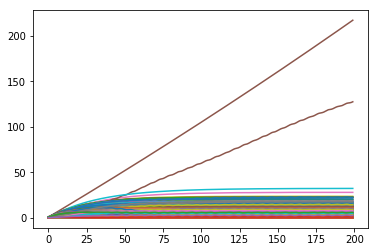

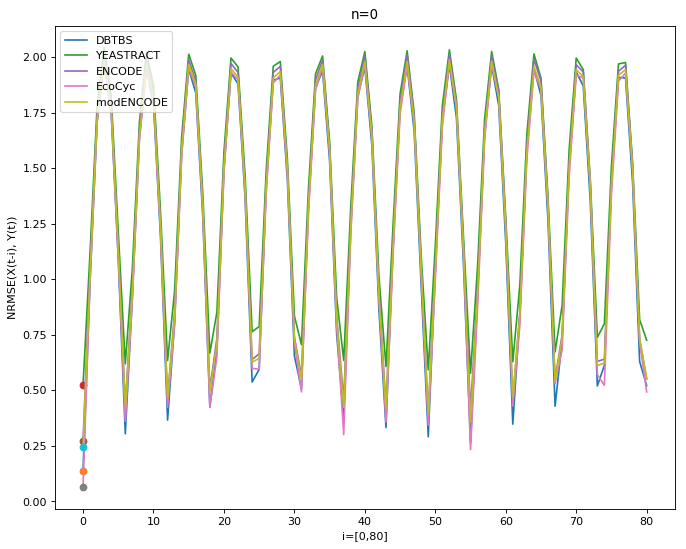

network_edge_list_DBTBS.csv
False
1.70908345184
13  FINISHED
network_edge_list_YEASTRACT.csv
True
1.75752775952
289  FINISHED
network_edge_list_ENCODE.csv
True
1.78461685918
207  FINISHED
network_edge_list_EcoCyc.csv
False
1.71567939694
70  FINISHED
network_edge_list_modENCODE.csv
False
1.70840640685
486  FINISHED
DBTBS => min= 2
YEASTRACT => min= 2
ENCODE => min= 2
EcoCyc => min= 2
modENCODE => min= 2


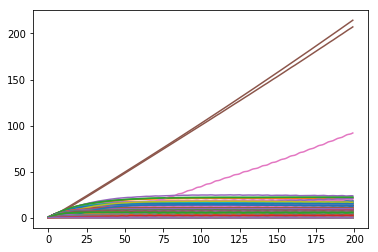

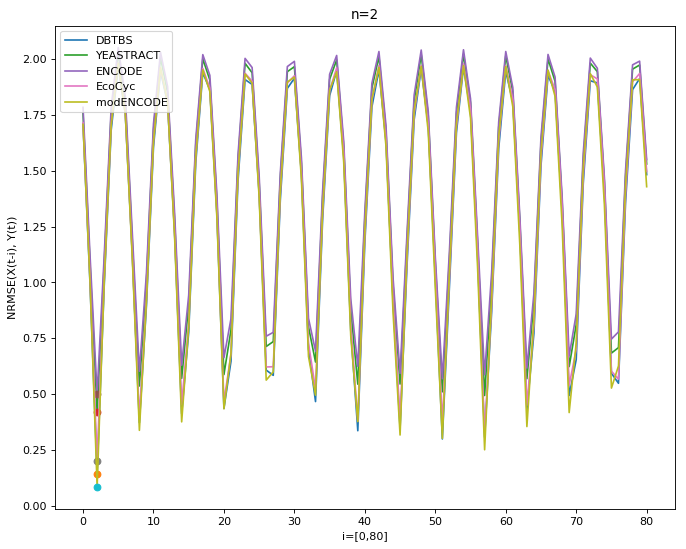

network_edge_list_DBTBS.csv
False
1.08549044403
13  FINISHED
network_edge_list_YEASTRACT.csv
True
1.305031712
289  FINISHED
network_edge_list_ENCODE.csv
False
1.14071857058
207  FINISHED
network_edge_list_EcoCyc.csv
False
1.10153657725
70  FINISHED
network_edge_list_modENCODE.csv
True
1.12374238273
486  FINISHED
DBTBS => min= 5
YEASTRACT => min= 5
ENCODE => min= 5
EcoCyc => min= 5
modENCODE => min= 5


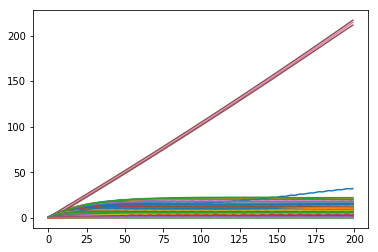

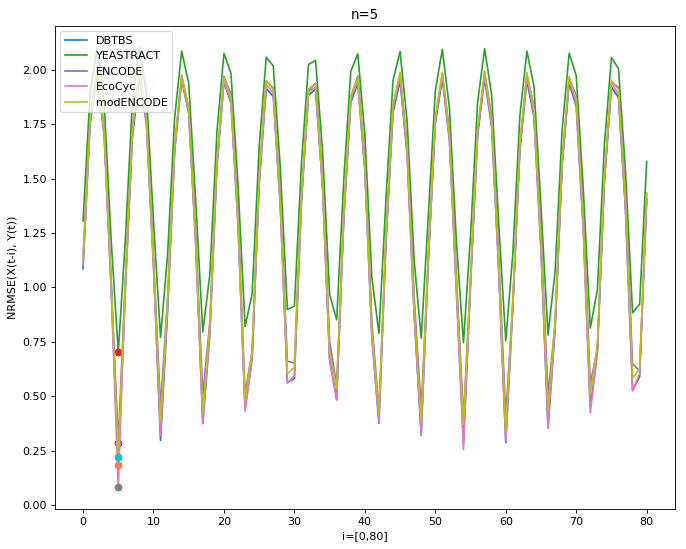

network_edge_list_DBTBS.csv
False
1.77035269086
13  FINISHED
network_edge_list_YEASTRACT.csv
False
2.15101314138
289  FINISHED
network_edge_list_ENCODE.csv
False
1.80641180363
207  FINISHED
network_edge_list_EcoCyc.csv
False
1.80325264355
70  FINISHED
network_edge_list_modENCODE.csv
True
1.84079280918
486  FINISHED
DBTBS => min= 16
YEASTRACT => min= 10
ENCODE => min= 10
EcoCyc => min= 10
modENCODE => min= 10


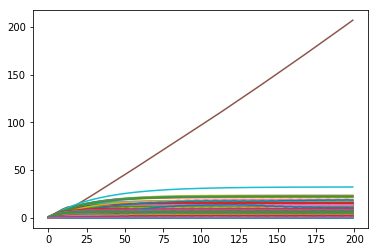

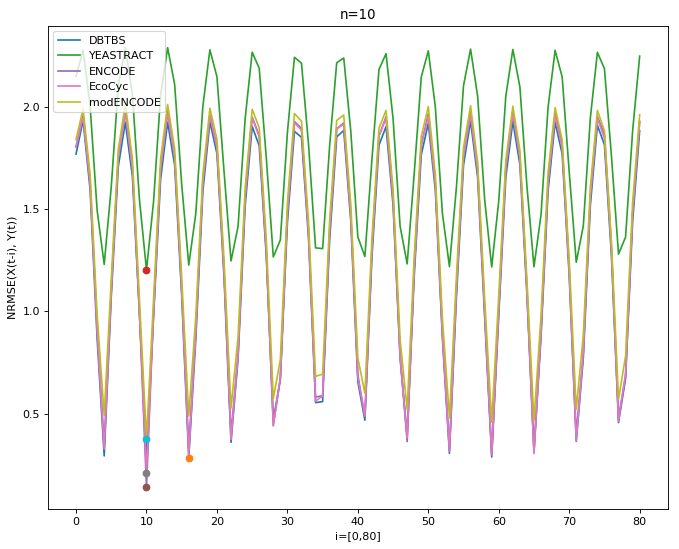

network_edge_list_DBTBS.csv
False
0.537410633933
13  FINISHED
network_edge_list_YEASTRACT.csv
True
0.596154420287
289  FINISHED
network_edge_list_ENCODE.csv
True
1.11069604019
207  FINISHED
network_edge_list_EcoCyc.csv
False
0.56822486091
70  FINISHED
network_edge_list_modENCODE.csv
True
0.899705415843
486  FINISHED
DBTBS => min= 19
YEASTRACT => min= 25
ENCODE => min= 25
EcoCyc => min= 25
modENCODE => min= 25


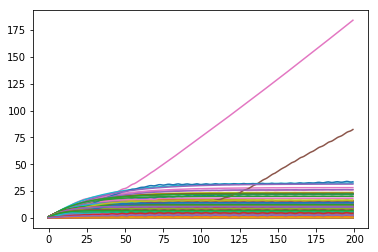

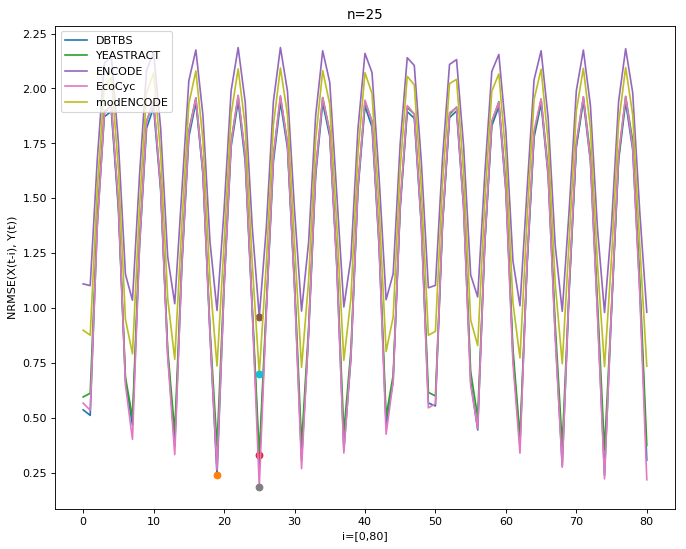

In [19]:
for n in [0,2,5,10,25]:
    X_by_file, Y_by_file, NRMSE_by_file,MI_by_file=testing_gene_net_derivative("Dataset1/", a,b,c,n)
    figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
    title("n="+str(n))
    plot_dict_by_file(NRMSE_by_file,n,save=False)

In [ ]:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                ##SINGLE FILE
#una n

In [ ]:
X,Y,nrmse_i,mi_i=testing_gene_net_derivative_file("Dataset1",csv_files[-1],a=a,b=b,c=c,n=20)
plot_dict_i("DBTBS", nrmse_i)
show()

In [ ]:
#rango de n

In [ ]:
file=csv_files[-1]
filename=file[file.index("list")+5:file.index(".csv")]

for n in [0,25,30]:
    X,Y,nrmse_i,mi_i=testing_gene_net_derivative_file("Dataset1",file,a=a,b=b,c=c,n=n)
    
    figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
    title("n="+str(n))
    plot_dict_i(filename, nrmse_i)
    savefig("plots/nrmse_i/%s_n%d_decay_random" %(filename,n))
    show()
    
    figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
    plot_temporal_lines(X,Y, n, testLen,filename)
    
    
    figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
    plot_temporal_lines(X,Y, n, 50,filename)
   

In [ ]:
#MUTUAL INFO
file=csv_files[-1]
filename=file[file.index("list")+5:file.index(".csv")]

for n in [0,15,20,25,30,50,60,80]:
    X,Y,nrmse_i,mi_i=testing_gene_net_derivative_file("Dataset1",file,a=a,b=b,c=c,n=n)
    
    figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
    title("n="+str(n))
    plot_dict_i(filename, mi_i,nrmse=False)
    #savefig("plots/nrmse_i/%s_n%d" %(filename,n))
    show()
    
    figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
    plot_temporal_lines(X,Y, n, testLen,filename, save=False)
    
    
    figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
    plot_temporal_lines(X,Y, n, 50,filename,save=False)
   